In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot
from utils import confusion_matrix,metrics_scores,pff

from model import FixCapsNet

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}

#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [4]:
def get_data(trans_test='312'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((302,302)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    data_root = os.path.abspath(os.path.join(os.getcwd(),".."))  # get data root path
    image_path = os.path.join(data_root, "datasets","HAM10000")#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)
    
    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)
        
    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [5]:
BatchSize = 168
V_size = 40 
T_size = 32 
train_doc = "train525e384"
val_doc = "val525png384"
test_doc = "test525png384"

nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 6 dataloader workers every process.
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.


In [6]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 136, 136]         323,072
              ReLU-2        [-1, 128, 136, 136]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(29, 29), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [8]:
dsize = (1, 3, 299, 299)
input_data = torch.randn(dsize).to(device)
pff(m_name="FixCaps"+'-'+mode,model=network,inputes=input_data)

  Model   | Params(M) | FLOPs(G) | FPS
----------|-----------|----------|-----
FixCaps-128 |    0.46   |   5.99   | 119.8


In [9]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()     
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 80: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [10]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result) 
        test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
                torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")
    

In [11]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: "./tmp/{img_title}/{suf}"')
else:
    !mkdir -p ./tmp/{img_title}/{suf} 
iter_path = f'./tmp/{img_title}/{suf}/train_{img_title}_{suf}.pth'
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
last_path = f'./tmp/{img_title}/{suf}/last_{img_title}_{suf}.pth'
print(save_PATH)

suf:1027_201233
./tmp/HAM10000/1027_201233/best_HAM10000_1027_201233.pth


In [12]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate,
#                         steps_per_epoch=len(train_loader),
#                         epochs=num_epochs)

In [13]:
num_epochs = 120

In [14]:
for epoch in range(1, num_epochs + 1): #4h 26m 46s
    train(epoch)
    test('val')
    
print('Finished Training')

[Train Epoch:[1]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.37458,ACC:0.33225
Train Epoch:[1] Loss:0.40071,Acc:0.38137,Best_train:0.38137
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:55.964%
Best_val:[55.964%]
[Train Epoch:[2]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.36375,ACC:0.46989
Train Epoch:[2] Loss:0.34003,Acc:0.48019,Best_train:0.48019
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:67.396%
Best_val:[67.396%]
[Train Epoch:[3]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.30176,ACC:0.52052
Train Epoch:[3] Loss:0.31163,Acc:0.53021,Best_train:0.53021
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:69.085%
Best_val:[69.085%]
[Train Epoch:[4]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28955,ACC:0.55400
Train Epoch:[4] Loss:0.29606,Acc:0.55629,Best_train:0.55629
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:66.6%
Best_val:[69.085%]
[Train Epoch:[5]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.30727,ACC:0.57224
Train Epoch:[5] Loss:0.28519,Acc:0.57187,Best_train:0.57187
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:73.161%
Best_val:[73.161%]
[Train Epoch:[6]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28664,ACC:0.57583
Train Epoch:[6] Loss:0.28362,Acc:0.57470,Best_train:0.57470
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:73.161%
Best_val:[73.161%]
[Train Epoch:[7]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.29165,ACC:0.57842
Train Epoch:[7] Loss:0.28125,Acc:0.57898,Best_train:0.57898
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:73.658%
Best_val:[73.658%]
[Train Epoch:[8]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27693,ACC:0.57104
Train Epoch:[8] Loss:0.28301,Acc:0.57640,Best_train:0.57898
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:73.956%
Best_val:[73.956%]
[Train Epoch:[9]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.30457,ACC:0.57630
Train Epoch:[9] Loss:0.28349,Acc:0.57985,Best_train:0.57985
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:67.694%
Best_val:[73.956%]
[Train Epoch:[10]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25994,ACC:0.58082
Train Epoch:[10] Loss:0.28145,Acc:0.58217,Best_train:0.58217
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:74.751%
Best_val:[74.751%]
[Train Epoch:[11]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27203,ACC:0.59381
Train Epoch:[11] Loss:0.27431,Acc:0.59557,Best_train:0.59557
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:74.652%
Best_val:[74.751%]
[Train Epoch:[12]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28018,ACC:0.60598
Train Epoch:[12] Loss:0.26435,Acc:0.61213,Best_train:0.61213
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.529%
Best_val:[78.529%]
[Train Epoch:[13]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22159,ACC:0.62674
Train Epoch:[13] Loss:0.25643,Acc:0.62481,Best_train:0.62481
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.137%
Best_val:[78.529%]
[Train Epoch:[14]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26232,ACC:0.63721
Train Epoch:[14] Loss:0.24723,Acc:0.64082,Best_train:0.64082
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.417%
Best_val:[80.417%]
[Train Epoch:[15]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23038,ACC:0.65519
Train Epoch:[15] Loss:0.24055,Acc:0.65324,Best_train:0.65324
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.243%
Best_val:[80.417%]
[Train Epoch:[16]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22275,ACC:0.65712
Train Epoch:[16] Loss:0.23917,Acc:0.65521,Best_train:0.65521
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.728%
Best_val:[80.417%]
[Train Epoch:[17]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21870,ACC:0.64842
Train Epoch:[17] Loss:0.24048,Acc:0.64878,Best_train:0.65521
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.225%
Best_val:[80.417%]
[Train Epoch:[18]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22847,ACC:0.64869
Train Epoch:[18] Loss:0.24360,Acc:0.64741,Best_train:0.65521
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.839%
Best_val:[80.417%]
[Train Epoch:[19]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24652,ACC:0.64062
Train Epoch:[19] Loss:0.24761,Acc:0.64162,Best_train:0.65521
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.92%
Best_val:[80.417%]
[Train Epoch:[20]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24147,ACC:0.63733
Train Epoch:[20] Loss:0.24763,Acc:0.63935,Best_train:0.65521
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.143%
Best_val:[80.417%]
[Train Epoch:[21]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26468,ACC:0.64201
Train Epoch:[21] Loss:0.24657,Acc:0.64365,Best_train:0.65521
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.02%
Best_val:[80.417%]
[Train Epoch:[22]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26297,ACC:0.65175
Train Epoch:[22] Loss:0.24129,Acc:0.65355,Best_train:0.65521
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.909%
Best_val:[81.909%]
[Train Epoch:[23]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22749,ACC:0.65948
Train Epoch:[23] Loss:0.23599,Acc:0.66067,Best_train:0.66067
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.095%
Best_val:[84.095%]
[Train Epoch:[24]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20221,ACC:0.67038
Train Epoch:[24] Loss:0.22783,Acc:0.67428,Best_train:0.67428
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[84.095%]
[Train Epoch:[25]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19073,ACC:0.68259
Train Epoch:[25] Loss:0.22305,Acc:0.68230,Best_train:0.68230
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.107%
Best_val:[84.095%]
[Train Epoch:[26]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22054,ACC:0.68495
Train Epoch:[26] Loss:0.22040,Acc:0.68336,Best_train:0.68336
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.406%
Best_val:[84.095%]
[Train Epoch:[27]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20529,ACC:0.68924
Train Epoch:[27] Loss:0.22052,Acc:0.68611,Best_train:0.68611
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[84.095%]
[Train Epoch:[28]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21758,ACC:0.67629
Train Epoch:[28] Loss:0.22538,Acc:0.67711,Best_train:0.68611
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.113%
Best_val:[84.095%]
[Train Epoch:[29]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21806,ACC:0.67424
Train Epoch:[29] Loss:0.22818,Acc:0.67424,Best_train:0.68611
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.008%
Best_val:[84.095%]
[Train Epoch:[30]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26027,ACC:0.66879
Train Epoch:[30] Loss:0.23254,Acc:0.66570,Best_train:0.68611
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.044%
Best_val:[84.095%]
[Train Epoch:[31]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23266,ACC:0.67266
Train Epoch:[31] Loss:0.23126,Acc:0.66925,Best_train:0.68611
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.704%
Best_val:[84.095%]
[Train Epoch:[32]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23445,ACC:0.67977
Train Epoch:[32] Loss:0.22693,Acc:0.67837,Best_train:0.68611
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.312%
Best_val:[84.095%]
[Train Epoch:[33]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24450,ACC:0.68506
Train Epoch:[33] Loss:0.22132,Acc:0.68646,Best_train:0.68646
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.815%
Best_val:[84.095%]
[Train Epoch:[34]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25089,ACC:0.69828
Train Epoch:[34] Loss:0.21393,Acc:0.69889,Best_train:0.69889
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.505%
Best_val:[84.095%]
[Train Epoch:[35]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21543,ACC:0.70551
Train Epoch:[35] Loss:0.20861,Acc:0.70776,Best_train:0.70776
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.505%
Best_val:[84.095%]
[Train Epoch:[36]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20424,ACC:0.71599
Train Epoch:[36] Loss:0.20685,Acc:0.71485,Best_train:0.71485
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[84.095%]
[Train Epoch:[37]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19676,ACC:0.71038
Train Epoch:[37] Loss:0.20731,Acc:0.71142,Best_train:0.71485
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.996%
Best_val:[84.095%]
[Train Epoch:[38]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22164,ACC:0.70312
Train Epoch:[38] Loss:0.21142,Acc:0.70286,Best_train:0.71485
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.616%
Best_val:[84.095%]
[Train Epoch:[39]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23041,ACC:0.69840
Train Epoch:[39] Loss:0.21539,Acc:0.69779,Best_train:0.71485
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.207%
Best_val:[84.095%]
[Train Epoch:[40]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22904,ACC:0.68796
Train Epoch:[40] Loss:0.22011,Acc:0.68886,Best_train:0.71485
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:74.851%
Best_val:[84.095%]
[Train Epoch:[41]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20324,ACC:0.68704
Train Epoch:[41] Loss:0.22009,Acc:0.69028,Best_train:0.71485
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[84.095%]
[Train Epoch:[42]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20830,ACC:0.69639
Train Epoch:[42] Loss:0.21501,Acc:0.69878,Best_train:0.71485
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:74.254%
Best_val:[84.095%]
[Train Epoch:[43]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21703,ACC:0.70829
Train Epoch:[43] Loss:0.20853,Acc:0.70877,Best_train:0.71485
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.125%
Best_val:[84.095%]
[Train Epoch:[44]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17305,ACC:0.71927
Train Epoch:[44] Loss:0.20306,Acc:0.72042,Best_train:0.72042
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.575%
Best_val:[87.575%]
[Train Epoch:[45]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18051,ACC:0.72638
Train Epoch:[45] Loss:0.19792,Acc:0.72645,Best_train:0.72645
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.388%
Best_val:[87.575%]
[Train Epoch:[46]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20895,ACC:0.72955
Train Epoch:[46] Loss:0.19641,Acc:0.72943,Best_train:0.72943
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.984%
Best_val:[87.575%]
[Train Epoch:[47]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19196,ACC:0.73137
Train Epoch:[47] Loss:0.19636,Acc:0.73061,Best_train:0.73061
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.282%
Best_val:[87.575%]
[Train Epoch:[48]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20448,ACC:0.72132
Train Epoch:[48] Loss:0.20094,Acc:0.72060,Best_train:0.73061
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.575%
Best_val:[87.575%]
[Train Epoch:[49]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22027,ACC:0.70907
Train Epoch:[49] Loss:0.20769,Acc:0.70970,Best_train:0.73061
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:73.26%
Best_val:[87.575%]
[Train Epoch:[50]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24316,ACC:0.70443
Train Epoch:[50] Loss:0.21150,Acc:0.70364,Best_train:0.73061
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.441%
Best_val:[87.575%]
[Train Epoch:[51]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20308,ACC:0.70543
Train Epoch:[51] Loss:0.21104,Acc:0.70617,Best_train:0.73061
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.382%
Best_val:[87.575%]
[Train Epoch:[52]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21899,ACC:0.71069
Train Epoch:[52] Loss:0.20739,Acc:0.71268,Best_train:0.73061
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[87.575%]
[Train Epoch:[53]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19764,ACC:0.71691
Train Epoch:[53] Loss:0.20165,Acc:0.72151,Best_train:0.73061
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.195%
Best_val:[87.575%]
[Train Epoch:[54]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19766,ACC:0.73176
Train Epoch:[54] Loss:0.19530,Acc:0.73316,Best_train:0.73316
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.803%
Best_val:[87.575%]
[Train Epoch:[55]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18273,ACC:0.74366
Train Epoch:[55] Loss:0.19014,Acc:0.73963,Best_train:0.73963
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.873%
Best_val:[87.873%]
[Train Epoch:[56]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21445,ACC:0.73933
Train Epoch:[56] Loss:0.18937,Acc:0.74017,Best_train:0.74017
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.481%
Best_val:[87.873%]
[Train Epoch:[57]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19579,ACC:0.74312
Train Epoch:[57] Loss:0.18922,Acc:0.74128,Best_train:0.74128
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:88.469%
Best_val:[88.469%]
[Train Epoch:[58]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18910,ACC:0.73875
Train Epoch:[58] Loss:0.19323,Acc:0.73533,Best_train:0.74128
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.225%
Best_val:[88.469%]
[Train Epoch:[59]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17367,ACC:0.72101
Train Epoch:[59] Loss:0.20065,Acc:0.72180,Best_train:0.74128
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.622%
Best_val:[88.469%]
[Train Epoch:[60]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21699,ACC:0.71270
Train Epoch:[60] Loss:0.20469,Acc:0.71754,Best_train:0.74128
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.978%
Best_val:[88.469%]
[Train Epoch:[61]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21068,ACC:0.71850
Train Epoch:[61] Loss:0.20360,Acc:0.71847,Best_train:0.74128
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:74.155%
Best_val:[88.469%]
[Train Epoch:[62]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21898,ACC:0.72291
Train Epoch:[62] Loss:0.20181,Acc:0.72335,Best_train:0.74128
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.038%
Best_val:[88.469%]
[Train Epoch:[63]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18902,ACC:0.73365
Train Epoch:[63] Loss:0.19707,Acc:0.73026,Best_train:0.74128
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:88.072%
Best_val:[88.469%]
[Train Epoch:[64]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20604,ACC:0.74026
Train Epoch:[64] Loss:0.18996,Acc:0.74048,Best_train:0.74128
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.581%
Best_val:[88.469%]
[Train Epoch:[65]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18724,ACC:0.75189
Train Epoch:[65] Loss:0.18352,Acc:0.75094,Best_train:0.75094
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.493%
Best_val:[88.469%]
[Train Epoch:[66]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14091,ACC:0.75004
Train Epoch:[66] Loss:0.18276,Acc:0.75218,Best_train:0.75218
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.394%
Best_val:[88.469%]
[Train Epoch:[67]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18794,ACC:0.74842
Train Epoch:[67] Loss:0.18376,Acc:0.75069,Best_train:0.75218
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[88.469%]
[Train Epoch:[68]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18007,ACC:0.74660
Train Epoch:[68] Loss:0.18771,Acc:0.74449,Best_train:0.75218
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.984%
Best_val:[88.469%]
[Train Epoch:[69]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17619,ACC:0.74134
Train Epoch:[69] Loss:0.19228,Acc:0.73953,Best_train:0.75218
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.779%
Best_val:[88.469%]
[Train Epoch:[70]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20584,ACC:0.73040
Train Epoch:[70] Loss:0.19794,Acc:0.72858,Best_train:0.75218
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.885%
Best_val:[88.469%]
[Train Epoch:[71]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22057,ACC:0.72495
Train Epoch:[71] Loss:0.20016,Acc:0.72567,Best_train:0.75218
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:89.96%
Best_val:[89.96%]
[Train Epoch:[72]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20909,ACC:0.72909
Train Epoch:[72] Loss:0.19691,Acc:0.73140,Best_train:0.75218
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.779%
Best_val:[89.96%]
[Train Epoch:[73]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19259,ACC:0.74154
Train Epoch:[73] Loss:0.19023,Acc:0.74077,Best_train:0.75218
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.429%
Best_val:[89.96%]
[Train Epoch:[74]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18406,ACC:0.75147
Train Epoch:[74] Loss:0.18415,Acc:0.75090,Best_train:0.75218
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.972%
Best_val:[89.96%]
[Train Epoch:[75]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19281,ACC:0.75433
Train Epoch:[75] Loss:0.17897,Acc:0.75739,Best_train:0.75739
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.773%
Best_val:[89.96%]
[Train Epoch:[76]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18809,ACC:0.75881
Train Epoch:[76] Loss:0.17909,Acc:0.75808,Best_train:0.75808
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.376%
Best_val:[89.96%]
[Train Epoch:[77]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18705,ACC:0.75742
Train Epoch:[77] Loss:0.17882,Acc:0.75805,Best_train:0.75808
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.68%
Best_val:[89.96%]
[Train Epoch:[78]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19063,ACC:0.75456
Train Epoch:[78] Loss:0.18261,Acc:0.75444,Best_train:0.75808
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.68%
Best_val:[89.96%]
[Train Epoch:[79]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20244,ACC:0.74412
Train Epoch:[79] Loss:0.18812,Acc:0.74410,Best_train:0.75808
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:88.569%
Best_val:[89.96%]
[Train Epoch:[80]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18950,ACC:0.73752
Train Epoch:[80] Loss:0.19234,Acc:0.73895,Best_train:0.75808
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:58.748%
Best_val:[89.96%]
[Train Epoch:[81]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20597,ACC:0.73945
Train Epoch:[81] Loss:0.19494,Acc:0.73417,Best_train:0.75808
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.909%
Best_val:[89.96%]
[Train Epoch:[82]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17973,ACC:0.73782
Train Epoch:[82] Loss:0.19178,Acc:0.73804,Best_train:0.75808
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.592%
Best_val:[89.96%]
[Train Epoch:[83]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15817,ACC:0.75116
Train Epoch:[83] Loss:0.18579,Acc:0.74984,Best_train:0.75808
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.207%
Best_val:[89.96%]
[Train Epoch:[84]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17212,ACC:0.75332
Train Epoch:[84] Loss:0.18041,Acc:0.75582,Best_train:0.75808
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.282%
Best_val:[89.96%]
[Train Epoch:[85]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17868,ACC:0.76569
Train Epoch:[85] Loss:0.17545,Acc:0.76395,Best_train:0.76395
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.785%
Best_val:[89.96%]
[Train Epoch:[86]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14424,ACC:0.76701
Train Epoch:[86] Loss:0.17535,Acc:0.76627,Best_train:0.76627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.575%
Best_val:[89.96%]
[Train Epoch:[87]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15343,ACC:0.76558
Train Epoch:[87] Loss:0.17408,Acc:0.76606,Best_train:0.76627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:89.364%
Best_val:[89.96%]
[Train Epoch:[88]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17799,ACC:0.75816
Train Epoch:[88] Loss:0.17953,Acc:0.75830,Best_train:0.76627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.084%
Best_val:[89.96%]
[Train Epoch:[89]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18195,ACC:0.74784
Train Epoch:[89] Loss:0.18485,Acc:0.75026,Best_train:0.76627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.388%
Best_val:[89.96%]
[Train Epoch:[90]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17198,ACC:0.74733
Train Epoch:[90] Loss:0.18897,Acc:0.74658,Best_train:0.76627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.785%
Best_val:[89.96%]
[Train Epoch:[91]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21610,ACC:0.73392
Train Epoch:[91] Loss:0.19047,Acc:0.74073,Best_train:0.76627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.219%
Best_val:[89.96%]
[Train Epoch:[92]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16881,ACC:0.74915
Train Epoch:[92] Loss:0.18813,Acc:0.74687,Best_train:0.76627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:89.563%
Best_val:[89.96%]
[Train Epoch:[93]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16589,ACC:0.75247
Train Epoch:[93] Loss:0.18313,Acc:0.75280,Best_train:0.76627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.99%
Best_val:[89.96%]
[Train Epoch:[94]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16328,ACC:0.76457
Train Epoch:[94] Loss:0.17718,Acc:0.76457,Best_train:0.76627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:90.656%
Best_val:[90.656%]
[Train Epoch:[95]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16132,ACC:0.77315
Train Epoch:[95] Loss:0.17167,Acc:0.77040,Best_train:0.77040
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:88.668%
Best_val:[90.656%]
[Train Epoch:[96]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18835,ACC:0.77052
Train Epoch:[96] Loss:0.17160,Acc:0.77038,Best_train:0.77040
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.779%
Best_val:[90.656%]
[Train Epoch:[97]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15830,ACC:0.77346
Train Epoch:[97] Loss:0.17045,Acc:0.77354,Best_train:0.77354
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.773%
Best_val:[90.656%]
[Train Epoch:[98]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17999,ACC:0.76565
Train Epoch:[98] Loss:0.17469,Acc:0.76755,Best_train:0.77354
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.095%
Best_val:[90.656%]
[Train Epoch:[99]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16422,ACC:0.75557
Train Epoch:[99] Loss:0.18233,Acc:0.75681,Best_train:0.77354
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:88.072%
Best_val:[90.656%]
[Train Epoch:[100]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18736,ACC:0.75271
Train Epoch:[100] Loss:0.18689,Acc:0.74914,Best_train:0.77354
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.201%
Best_val:[90.656%]
[Train Epoch:[101]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19939,ACC:0.74613
Train Epoch:[101] Loss:0.18772,Acc:0.74666,Best_train:0.77354
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.417%
Best_val:[90.656%]
[Train Epoch:[102]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17149,ACC:0.75456
Train Epoch:[102] Loss:0.18321,Acc:0.75297,Best_train:0.77354
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.592%
Best_val:[90.656%]
[Train Epoch:[103]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23080,ACC:0.75877
Train Epoch:[103] Loss:0.18070,Acc:0.75698,Best_train:0.77354
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.734%
Best_val:[90.656%]
[Train Epoch:[104]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19016,ACC:0.76558
Train Epoch:[104] Loss:0.17409,Acc:0.76734,Best_train:0.77354
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.984%
Best_val:[90.656%]
[Train Epoch:[105]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19561,ACC:0.77277
Train Epoch:[105] Loss:0.17132,Acc:0.77342,Best_train:0.77354
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.779%
Best_val:[90.656%]
[Train Epoch:[106]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14437,ACC:0.77682
Train Epoch:[106] Loss:0.16839,Acc:0.77627,Best_train:0.77627
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.487%
Best_val:[90.656%]
[Train Epoch:[107]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15366,ACC:0.77818
Train Epoch:[107] Loss:0.16897,Acc:0.77648,Best_train:0.77648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.481%
Best_val:[90.656%]
[Train Epoch:[108]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16333,ACC:0.77195
Train Epoch:[108] Loss:0.17268,Acc:0.77063,Best_train:0.77648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.996%
Best_val:[90.656%]
[Train Epoch:[109]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17509,ACC:0.76113
Train Epoch:[109] Loss:0.17910,Acc:0.76130,Best_train:0.77648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:88.27%
Best_val:[90.656%]
[Train Epoch:[110]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18426,ACC:0.75186
Train Epoch:[110] Loss:0.18376,Acc:0.75295,Best_train:0.77648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.891%
Best_val:[90.656%]
[Train Epoch:[111]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19243,ACC:0.74741
Train Epoch:[111] Loss:0.18642,Acc:0.74862,Best_train:0.77648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.412%
Best_val:[90.656%]
[Train Epoch:[112]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17438,ACC:0.75514
Train Epoch:[112] Loss:0.18186,Acc:0.75617,Best_train:0.77648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.084%
Best_val:[90.656%]
[Train Epoch:[113]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20189,ACC:0.76403
Train Epoch:[113] Loss:0.17666,Acc:0.76447,Best_train:0.77648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.704%
Best_val:[90.656%]
[Train Epoch:[114]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15544,ACC:0.77323
Train Epoch:[114] Loss:0.17135,Acc:0.77338,Best_train:0.77648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.095%
Best_val:[90.656%]
[Train Epoch:[115]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18920,ACC:0.77853
Train Epoch:[115] Loss:0.16738,Acc:0.77950,Best_train:0.77950
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.388%
Best_val:[90.656%]
[Train Epoch:[116]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15263,ACC:0.78030
Train Epoch:[116] Loss:0.16596,Acc:0.78173,Best_train:0.78173
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.183%
Best_val:[90.656%]
[Train Epoch:[117]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14820,ACC:0.77756
Train Epoch:[117] Loss:0.16671,Acc:0.77816,Best_train:0.78173
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.089%
Best_val:[90.656%]
[Train Epoch:[118]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17101,ACC:0.78034
Train Epoch:[118] Loss:0.17015,Acc:0.77452,Best_train:0.78173
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.002%
Best_val:[90.656%]
[Train Epoch:[119]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17313,ACC:0.76878
Train Epoch:[119] Loss:0.17617,Acc:0.76716,Best_train:0.78173
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[90.656%]
[Train Epoch:[120]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15233,ACC:0.76075
Train Epoch:[120] Loss:0.17945,Acc:0.75932,Best_train:0.78173
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.131%
Best_val:[90.656%]
Finished Training


In [15]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [94]
[Val] ACC:90.66%.


In [16]:
network.load_state_dict(torch.load(save_PATH))

for k in range(22,33):
    T_size = k
    print(f"T_size:{k}")
    for i in range(300,325):
        get_data(i)
        print(f"size:{i}")
        for j in range(5):
            test()
            if dict_imgSize.get(i) is None or dict_imgSize[i] < test_acc:
                dict_imgSize[i] = test_acc

                if dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc
                    
            elif dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc                 

T_size:22
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
T_size:23
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.256%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.256%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.377%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.377%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.377%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.498%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.498%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.618%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
T_size:24
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
T_size:25
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
T_size:26
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
T_size:27
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[96.618%]
T_size:28
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
T_size:29
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
T_size:30
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.618%]
T_size:31
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
T_size:32
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.618%]


In [17]:
show.conclusion(img_title=img_title) 
print(sorted(dict_imgSize.items(), key=lambda x: x[1] ,reverse=True)[0:9])
print(sorted(dict_batch.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [195]
[Test] ACC:96.62%.
[(313, 96.6183602809906), (303, 96.49758338928223), (304, 96.49758338928223), (305, 96.49758338928223), (314, 96.49758338928223), (315, 96.49758338928223), (316, 96.49758338928223), (309, 96.37681245803833), (311, 96.37681245803833)]
[(23, 96.6183602809906), (22, 96.25604152679443), (26, 95.89372277259827), (31, 95.77294588088989), (32, 95.77294588088989), (24, 95.652174949646), (25, 95.41062712669373), (30, 95.04830837249756), (28, 94.80676054954529)]


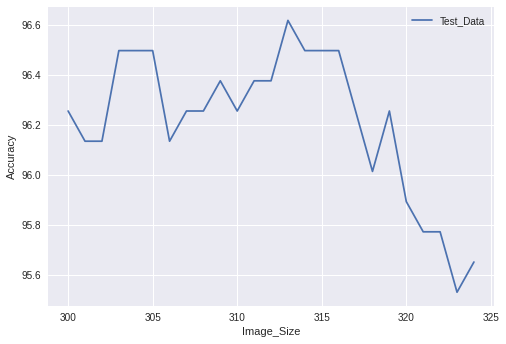

In [18]:
draw_size_acc(dict_imgSize,custom_path='./tmp',img_title=img_title,suf=suf)

In [19]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |    1.0    |  1.0   |  1.0  |          |
|  bcc   |   0.9259  | 0.962  | 0.943 |          |
|  bkl   |   0.9344  | 0.864  | 0.898 |          |
|   df   |   0.4444  | 0.667  | 0.533 |          |
|  mel   |   0.931   | 0.794  | 0.857 |          |
|   nv   |   0.9776  | 0.989  | 0.984 |          |
|  vasc  |    1.0    |  0.8   | 0.889 |          |
| Total: |           |        |       |  0.9662  |
+--------+-----------+--------+-------+----------+


In [20]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)
s4 = np.array(dict_batch)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_dict_batch_{suf}.npy', s2)

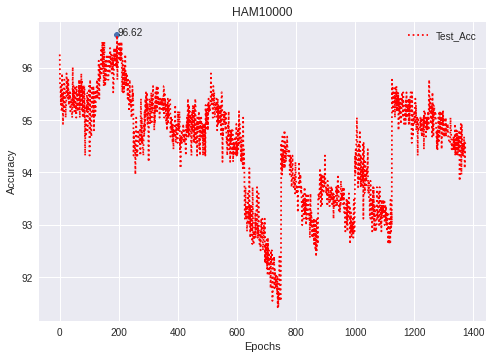

In [21]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

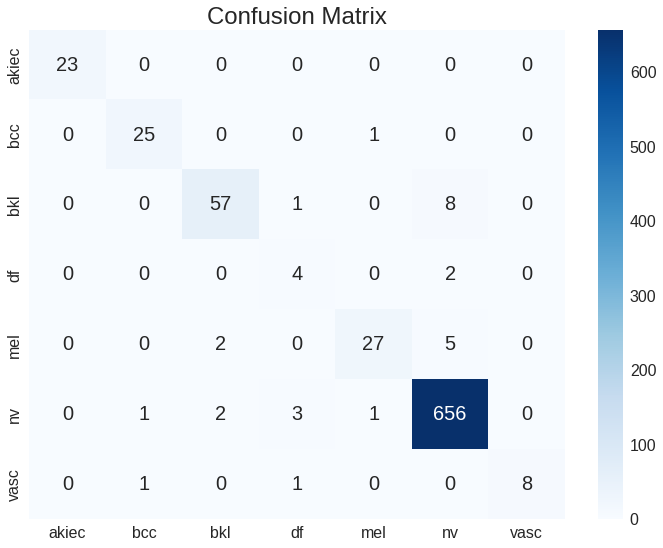

In [22]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

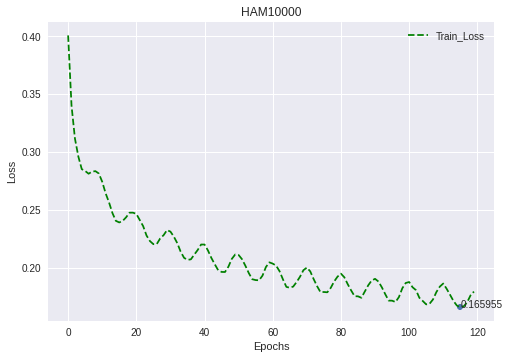

In [23]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

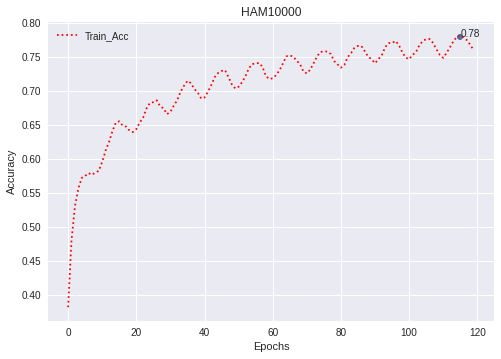

In [24]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

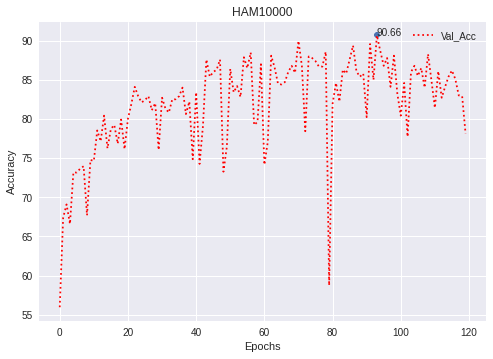

In [25]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

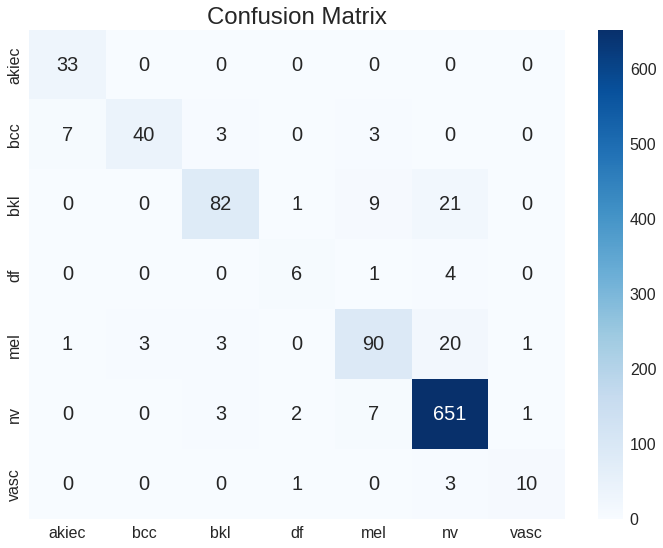

In [26]:
confusion_matrix(val_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

In [27]:
torch.cuda.memory.empty_cache()

In [28]:
stop

NameError: name 'stop' is not defined

In [33]:
network.load_state_dict(torch.load(save_PATH))
dict_test = {}
dict_size = {}
test_doc = "test525png384"#"test525png"#
for k in range(23,24):
    T_size = k
    for i in range(301,321):      
        get_data(i)
        print(f"size:{i}")
        for j in range(9):
            test()
            if dict_size.get(i) is None or dict_size[i] < test_acc:
                dict_size[i] = test_acc

                if dict_test.get(k) is None or dict_test[k] < test_acc:
                    dict_test[k] = test_acc

            elif dict_test.get(k) is None or dict_test[k] < test_acc:
                    dict_test[k] = test_acc

Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.618%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.618%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.498%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.377%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.256%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:96.135%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.618%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.618%]


In [34]:
show.conclusion(img_title=img_title) 
print(sorted(dict_test.items(), key=lambda x: x[1], reverse=True)[0:9])
print(sorted(dict_size.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [195]
[Test] ACC:96.62%.
[(23, 96.6183602809906)]
[(304, 96.6183602809906), (311, 96.6183602809906), (303, 96.49758338928223), (308, 96.49758338928223), (310, 96.49758338928223), (312, 96.49758338928223), (313, 96.49758338928223), (314, 96.49758338928223), (305, 96.37681245803833)]


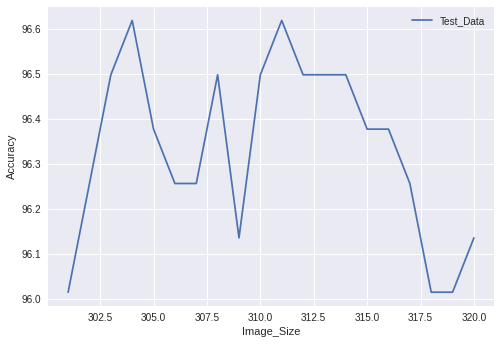

In [35]:
draw_size_acc(dict_size,custom_path='./tmp',img_title=img_title,suf=suf)

In [36]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |    1.0    |  1.0   |  1.0  |          |
|  bcc   |   0.9259  | 0.962  | 0.943 |          |
|  bkl   |   0.9492  | 0.848  | 0.896 |          |
|   df   |    0.5    | 0.667  | 0.571 |          |
|  mel   |    0.9    | 0.794  | 0.844 |          |
|   nv   |   0.9762  | 0.991  | 0.984 |          |
|  vasc  |    1.0    |  0.8   | 0.889 |          |
| Total: |           |        |       |  0.9662  |
+--------+-----------+--------+-------+----------+


In [ ]:
# network.load_state_dict(torch.load(save_PATH))
# dict_test = {}
# dict_size = {}
# test_doc = "test525png384"#"test525png"#
# for k in range(22,33):
#     T_size = k
#     for i in range(300,308):      
#         get_data(i)
#         print(f"size:{i}")
#         for j in range(7):
#             test()
#             if dict_size.get(i) is None or dict_size[i] < test_acc:
#                 dict_size[i] = test_acc

#                 if dict_test.get(k) is None or dict_test[k] < test_acc:
#                     dict_test[k] = test_acc

#             elif dict_test.get(k) is None or dict_test[k] < test_acc:
#                     dict_test[k] = test_acc

In [ ]:
# show.conclusion(img_title=img_title) 
# print(sorted(dict_test.items(), key=lambda x: x[1], reverse=True)[0:9])
# print(sorted(dict_size.items(), key=lambda x: x[1], reverse=True)[0:9])